In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/home/sudhinak/Divyansh: ['APT']
/home/sudhinak/Divyansh/APT: ['.ipynb_checkpoints', 'data_analysis.py', 'data', 'Untitled.ipynb', 'Untitled2.ipynb', 'data_analysis.ipynb', 'host_logs_analysis.ipynb', 'nystp', 'nystp.ipynb', 'apt_analysis.ipynb', 'Untitled1.ipynb']


In [2]:
pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv("nystp/prices-split-adjusted.csv", index_col=0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['MNK', 'PRU', 'PAYX', 'K', 'COH', 'WDC', 'MCD', 'IP', 'CERN', 'ALL']


In [4]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [5]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


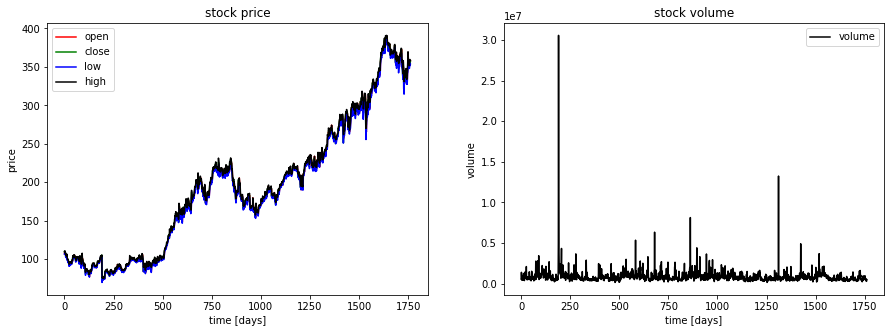

In [7]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [8]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)

    # split into train/valid/test (70/20/10 for example)
    train_split = int(0.7 * len(data))
    valid_split = int(0.9 * len(data))

    x_train = data[:train_split, :-1, :]
    y_train = data[:train_split, -1, :]

    x_valid = data[train_split:valid_split, :-1, :]
    y_valid = data[train_split:valid_split, -1, :]

    x_test = data[valid_split:, :-1, :]
    y_test = data[valid_split:, -1, :]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1219, 19, 4)
y_train.shape =  (1219, 4)
x_valid.shape =  (348, 19, 4)
y_valid.shape =  (348, 4)
x_test.shape =  (175, 19, 4)
y_test.shape =  (175, 4)


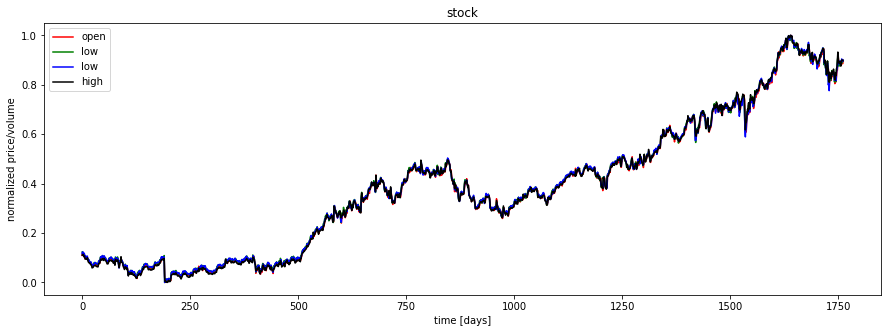

In [9]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [17]:
import tensorflow as tf

def create_optimized_rnn_model(n_steps, n_inputs, n_outputs, cell_type='gru'):
    """
    Optimized RNN model with tuned hyperparameters.
    """
    n_layers = 2
    n_neurons = [128, 64]   # progressively smaller
    dropout_rate = 0.2

    model = tf.keras.Sequential()

    for i in range(n_layers):
        return_sequences = (i < n_layers - 1)

        if cell_type == 'gru':
            layer = tf.keras.layers.GRU(
                n_neurons[i],
                activation='tanh',
                return_sequences=return_sequences,
                dropout=dropout_rate,
                recurrent_dropout=dropout_rate,
                input_shape=(n_steps, n_inputs) if i == 0 else None
            )
        elif cell_type == 'lstm':
            layer = tf.keras.layers.LSTM(
                n_neurons[i],
                activation='tanh',
                return_sequences=return_sequences,
                dropout=dropout_rate,
                recurrent_dropout=dropout_rate,
                input_shape=(n_steps, n_inputs) if i == 0 else None
            )
        elif cell_type == 'basic_rnn':
            layer = tf.keras.layers.SimpleRNN(
                n_neurons[i],
                activation='tanh',
                return_sequences=return_sequences,
                dropout=dropout_rate,
                input_shape=(n_steps, n_inputs) if i == 0 else None
            )
        else:
            raise ValueError("Unsupported cell type")
        
        model.add(layer)

    model.add(tf.keras.layers.Dense(n_outputs))
    return model


def train_optimized_rnn(x_train, y_train, x_valid, y_valid, seq_len, cell_type='gru'):
    """
    Train the optimized RNN with early stopping and LR scheduler
    """
    n_steps = seq_len - 1
    n_inputs = x_train.shape[2]
    n_outputs = y_train.shape[1]

    model = create_optimized_rnn_model(n_steps, n_inputs, n_outputs, cell_type)

    # Compile with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Callbacks for early stopping and dynamic LR
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, verbose=1
        )
    ]

    # Train
    history = model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=200,
        batch_size=32,
        shuffle=True,
        callbacks=callbacks,
        verbose=2
    )

    return model, history


In [18]:
# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


# Method 1: Custom Training Loop (similar to your original code)
print("\n" + "="*50)
print("TRAINING WITH CUSTOM LOOP")
print("="*50)

# Train with Basic RNN
print("\nTraining Basic RNN...")
model_rnn, y_train_pred_rnn, y_valid_pred_rnn, y_test_pred_rnn = train_rnn_model(
    x_train, y_train, x_valid, y_valid, x_test, y_test, 
    seq_len=seq_len, 
    cell_type='basic_rnn'
)

# Train with LSTM
print("\nTraining LSTM...")
model_lstm, y_train_pred_lstm, y_valid_pred_lstm, y_test_pred_lstm = train_rnn_model(
    x_train, y_train, x_valid, y_valid, x_test, y_test, 
    seq_len=seq_len, 
    cell_type='lstm'
)

# Train with GRU
print("\nTraining GRU...")
model_gru, y_train_pred_gru, y_valid_pred_gru, y_test_pred_gru = train_rnn_model(
    x_train, y_train, x_valid, y_valid, x_test, y_test, 
    seq_len=seq_len, 
    cell_type='gru'
)


df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1219, 19, 4)
y_train.shape =  (1219, 4)
x_valid.shape =  (348, 19, 4)
y_valid.shape =  (348, 4)
x_test.shape =  (175, 19, 4)
y_test.shape =  (175, 4)

TRAINING WITH CUSTOM LOOP

Training Basic RNN...
Training with basic_rnn cells...
Model architecture: 2 layers, 200 neurons per layer
0.00 epochs: MSE train/valid = 0.949062/1.707278
4.96 epochs: MSE train/valid = 0.000210/0.001778
9.93 epochs: MSE train/valid = 0.000193/0.001481
14.89 epochs: MSE train/valid = 0.000196/0.001128
19.85 epochs: MSE train/valid = 0.000120/0.000772
24.82 epochs: MSE train/valid = 0.000160/0.000967
29.78 epochs: MSE train/valid = 0.000146/0.000933
34.74 epochs: MSE train/valid = 0.000134/0.000524
39.70 epochs: MSE train/valid = 0.000189/0.000997
44.67 epochs: MSE train/valid = 0.000087/0.000462
49.63 epochs: MSE train/valid = 0.000116/0.000559
54.59 epochs: MSE train/valid = 0.000089/0.000496
59.56 epochs: MSE train/valid = 0.000087

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Evaluate model performance"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{model_name} - {dataset_name}:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    return mse, mae, rmse

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Evaluate all models on test set
print("\nTest Set Performance:")
evaluate_model(y_test, y_test_pred_rnn, "Basic RNN", "Test")
evaluate_model(y_test, y_test_pred_lstm, "LSTM", "Test")
evaluate_model(y_test, y_test_pred_gru, "GRU", "Test")


MODEL EVALUATION

Test Set Performance:
Basic RNN - Test:
  MSE:  0.002538
  MAE:  0.045612
  RMSE: 0.050380
LSTM - Test:
  MSE:  0.001091
  MAE:  0.029622
  RMSE: 0.033027
GRU - Test:
  MSE:  0.000753
  MAE:  0.024980
  RMSE: 0.027439


(0.0007529107405263766, 0.02497952638563535, 0.027439219021801197)


Generating plots...


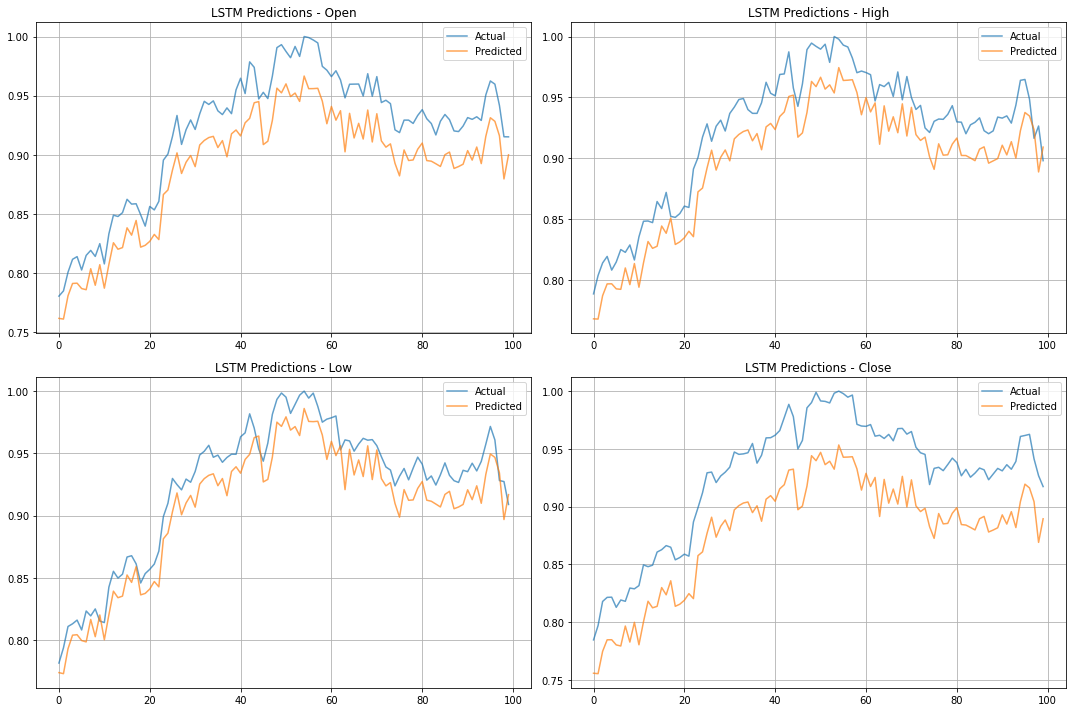

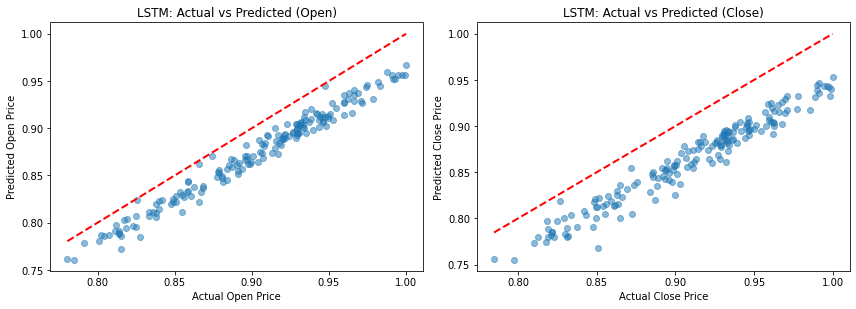

In [23]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title, feature_names=['Open', 'High', 'Low', 'Close']):
    """Plot actual vs predicted values"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i in range(min(4, y_true.shape[1])):
        axes[i].plot(y_true[:100, i], label='Actual', alpha=0.7)
        axes[i].plot(y_pred[:100, i], label='Predicted', alpha=0.7)
        axes[i].set_title(f'{title} - {feature_names[i]}')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results for different models
print("\nGenerating plots...")

# Plot LSTM results
plot_predictions(y_test, y_test_pred_lstm, "LSTM Predictions")

# Plot comparison between actual and predicted
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(y_test[:, 0], y_test_pred_lstm[:, 0], alpha=0.5)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2)
plt.xlabel('Actual Open Price')
plt.ylabel('Predicted Open Price')
plt.title('LSTM: Actual vs Predicted (Open)')

plt.subplot(2, 2, 2)
plt.scatter(y_test[:, 3], y_test_pred_lstm[:, 3], alpha=0.5)
plt.plot([y_test[:, 3].min(), y_test[:, 3].max()], 
         [y_test[:, 3].min(), y_test[:, 3].max()], 'r--', lw=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('LSTM: Actual vs Predicted (Close)')

plt.tight_layout()
plt.show()

#predictions:

LSTM MODEL VISUALIZATION

Visualizing Open prices...


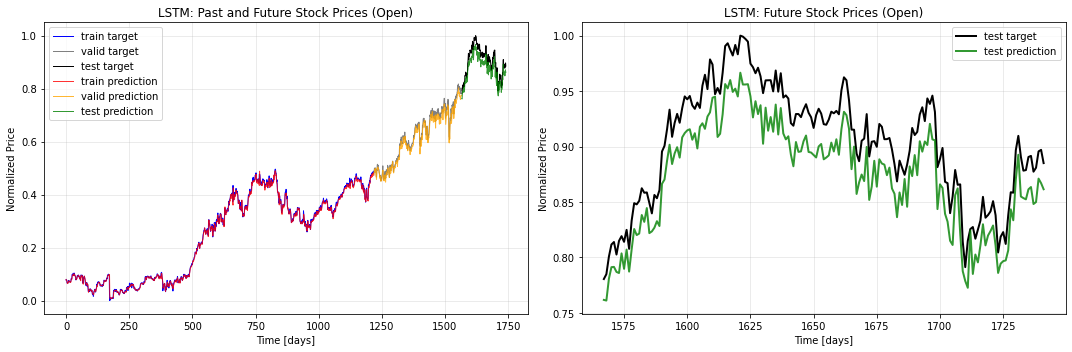


Visualizing High prices...


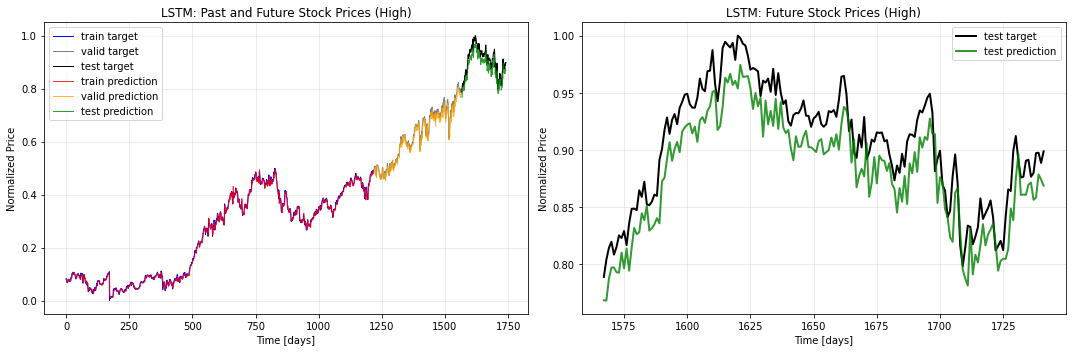


Visualizing Low prices...


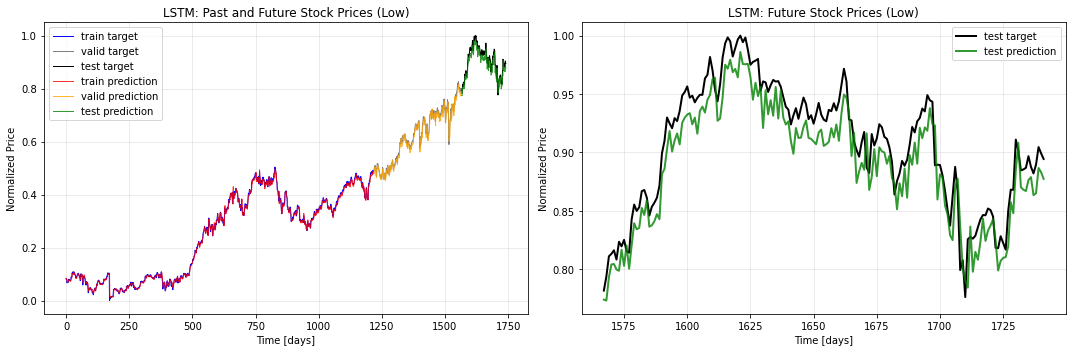


Visualizing Close prices...


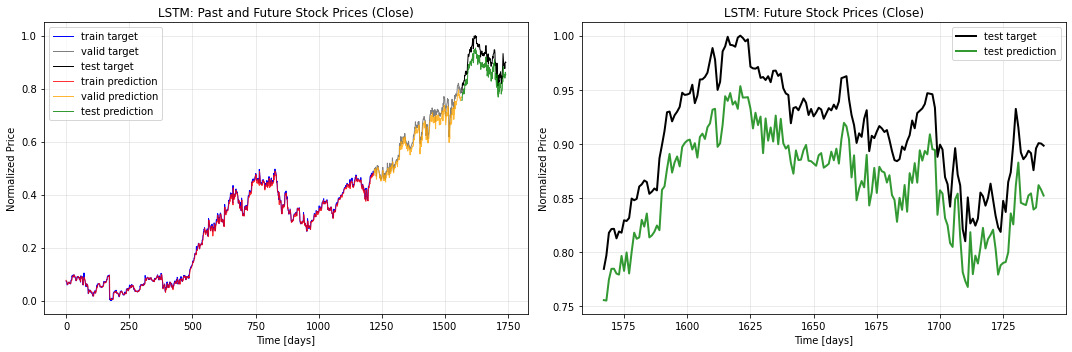


Directional Accuracy (Close - Open Price):
Train/Valid/Test: 0.69/0.40/0.22

MODEL COMPARISON

Directional Accuracy Comparison (Close - Open):
Basic RNN : 0.715/0.365/0.217
LSTM      : 0.692/0.399/0.217
GRU       : 0.600/0.635/0.783

Visualizing LSTM model for all features...


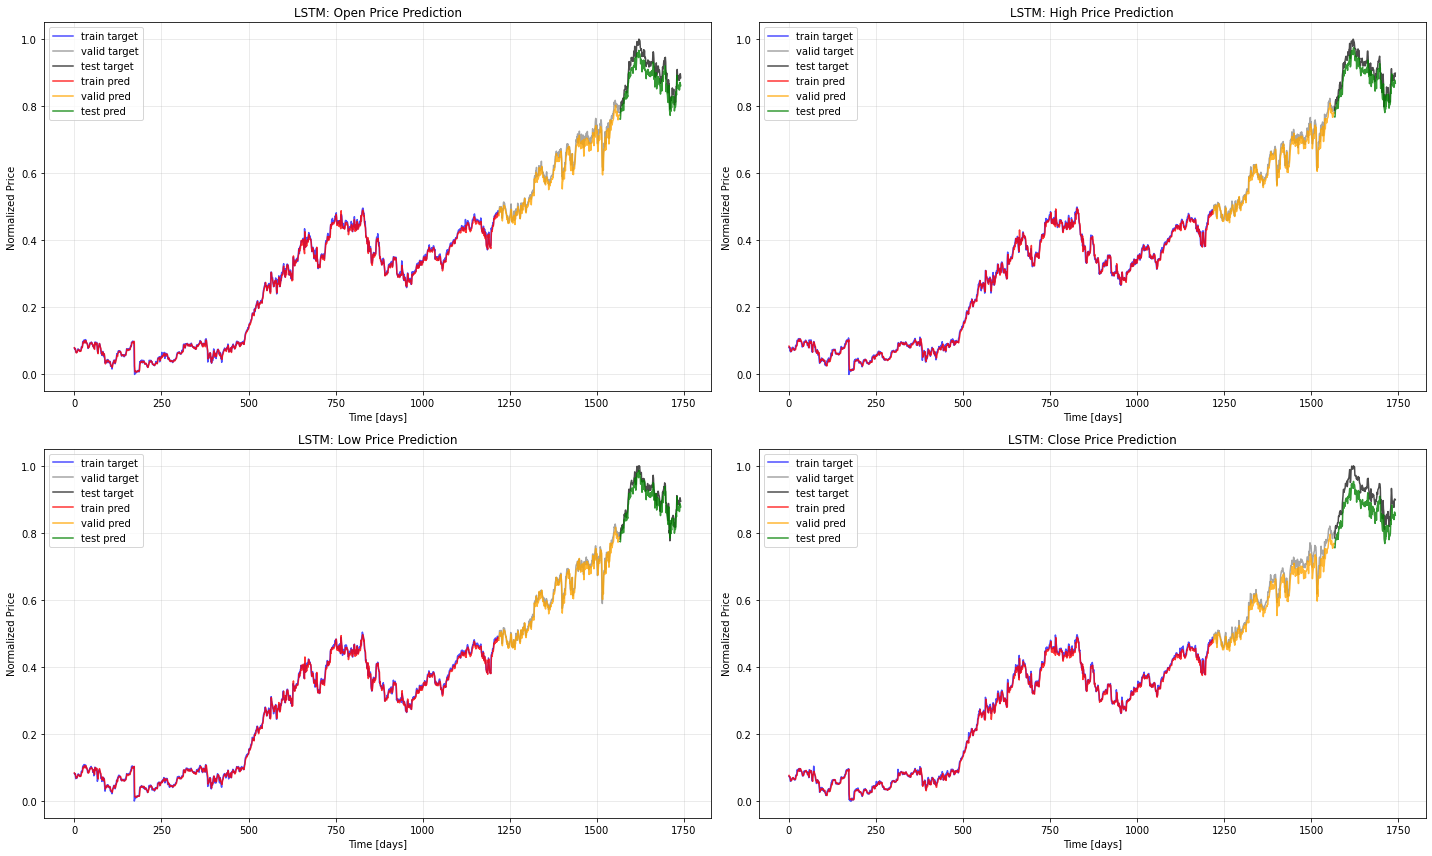

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred, 
                         model_name="RNN", ft=0):
    """
    Visualize stock price predictions
    
    Parameters:
    - y_train, y_valid, y_test: actual target values
    - y_train_pred, y_valid_pred, y_test_pred: predicted values
    - model_name: name of the model for title
    - ft: feature index (0=open, 1=high, 2=low, 3=close)
    """
    
    feature_names = ['Open', 'High', 'Low', 'Close']
    feature_name = feature_names[ft]
    
    plt.figure(figsize=(15, 5))
    
    # First subplot: Complete timeline
    plt.subplot(1, 2, 1)
    
    # Plot actual values
    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], 
             color='blue', label='train target', linewidth=1)
    
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]), 
             y_valid[:, ft], color='gray', label='valid target', linewidth=1)
    
    plt.plot(np.arange(y_train.shape[0] + y_valid.shape[0],
                      y_train.shape[0] + y_valid.shape[0] + y_test.shape[0]),
             y_test[:, ft], color='black', label='test target', linewidth=1)
    
    # Plot predictions
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft], 
             color='red', label='train prediction', linewidth=1, alpha=0.8)
    
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0]),
             y_valid_pred[:, ft], color='orange', label='valid prediction', linewidth=1, alpha=0.8)
    
    plt.plot(np.arange(y_train_pred.shape[0] + y_valid_pred.shape[0],
                      y_train_pred.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
             y_test_pred[:, ft], color='green', label='test prediction', linewidth=1, alpha=0.8)
    
    plt.title(f'{model_name}: Past and Future Stock Prices ({feature_name})')
    plt.xlabel('Time [days]')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Second subplot: Focus on test period
    plt.subplot(1, 2, 2)
    
    # Adjust x-axis for test period visualization
    test_start_idx = y_train.shape[0] + y_valid.shape[0]
    
    plt.plot(np.arange(test_start_idx, test_start_idx + y_test.shape[0]),
             y_test[:, ft], color='black', label='test target', linewidth=2)
    
    plt.plot(np.arange(test_start_idx, test_start_idx + y_test_pred.shape[0]),
             y_test_pred[:, ft], color='green', label='test prediction', linewidth=2, alpha=0.8)
    
    plt.title(f'{model_name}: Future Stock Prices ({feature_name})')
    plt.xlabel('Time [days]')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calculate_directional_accuracy(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred):
    """
    Calculate directional accuracy (correct sign prediction for close - open price)
    """
    # Calculate directional accuracy for train set
    corr_price_development_train = np.sum(np.equal(
        np.sign(y_train[:, 3] - y_train[:, 0]),  # close - open (actual)
        np.sign(y_train_pred[:, 3] - y_train_pred[:, 0])  # close - open (predicted)
    ).astype(int)) / y_train.shape[0]
    
    # Calculate directional accuracy for validation set
    corr_price_development_valid = np.sum(np.equal(
        np.sign(y_valid[:, 3] - y_valid[:, 0]),  # close - open (actual)
        np.sign(y_valid_pred[:, 3] - y_valid_pred[:, 0])  # close - open (predicted)
    ).astype(int)) / y_valid.shape[0]
    
    # Calculate directional accuracy for test set
    corr_price_development_test = np.sum(np.equal(
        np.sign(y_test[:, 3] - y_test[:, 0]),  # close - open (actual)
        np.sign(y_test_pred[:, 3] - y_test_pred[:, 0])  # close - open (predicted)
    ).astype(int)) / y_test.shape[0]
    
    return corr_price_development_train, corr_price_development_valid, corr_price_development_test

# Usage with your trained models:

# For LSTM model (using custom training)
print("="*60)
print("LSTM MODEL VISUALIZATION")
print("="*60)

# Convert TensorFlow tensors to numpy arrays if needed
if hasattr(y_train_pred_lstm, 'numpy'):
    y_train_pred_lstm_np = y_train_pred_lstm.numpy()
    y_valid_pred_lstm_np = y_valid_pred_lstm.numpy()
    y_test_pred_lstm_np = y_test_pred_lstm.numpy()
else:
    y_train_pred_lstm_np = y_train_pred_lstm
    y_valid_pred_lstm_np = y_valid_pred_lstm
    y_test_pred_lstm_np = y_test_pred_lstm

# Visualize for different features
feature_names = ['Open', 'High', 'Low', 'Close']

for ft in range(4):  # 0=open, 1=high, 2=low, 3=close
    print(f"\nVisualizing {feature_names[ft]} prices...")
    visualize_predictions(y_train, y_valid, y_test, 
                         y_train_pred_lstm_np, y_valid_pred_lstm_np, y_test_pred_lstm_np,
                         model_name="LSTM", ft=ft)

# Calculate and print directional accuracy
corr_train, corr_valid, corr_test = calculate_directional_accuracy(
    y_train, y_valid, y_test, 
    y_train_pred_lstm_np, y_valid_pred_lstm_np, y_test_pred_lstm_np
)

print('\nDirectional Accuracy (Close - Open Price):')
print('Train/Valid/Test: %.2f/%.2f/%.2f' % (corr_train, corr_valid, corr_test))

# Compare different models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

models = {
    'Basic RNN': (y_train_pred_rnn, y_valid_pred_rnn, y_test_pred_rnn),
    'LSTM': (y_train_pred_lstm_np, y_valid_pred_lstm_np, y_test_pred_lstm_np),
    'GRU': (y_train_pred_gru, y_valid_pred_gru, y_test_pred_gru)
}

# Calculate directional accuracy for all models
print("\nDirectional Accuracy Comparison (Close - Open):")
for model_name, (train_pred, valid_pred, test_pred) in models.items():
    # Convert to numpy if needed
    if hasattr(train_pred, 'numpy'):
        train_pred = train_pred.numpy()
        valid_pred = valid_pred.numpy()
        test_pred = test_pred.numpy()
    
    corr_train, corr_valid, corr_test = calculate_directional_accuracy(
        y_train, y_valid, y_test, train_pred, valid_pred, test_pred
    )
    print(f'{model_name:10}: {corr_train:.3f}/{corr_valid:.3f}/{corr_test:.3f}')

# Visualize best model on all features
print(f"\nVisualizing LSTM model for all features...")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.ravel()

for ft in range(4):
    ax = axes[ft]
    feature_name = feature_names[ft]
    
    # Complete timeline
    ax.plot(np.arange(y_train.shape[0]), y_train[:, ft], 
            color='blue', label='train target', alpha=0.7)
    ax.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]), 
            y_valid[:, ft], color='gray', label='valid target', alpha=0.7)
    ax.plot(np.arange(y_train.shape[0] + y_valid.shape[0],
                     y_train.shape[0] + y_valid.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target', alpha=0.7)
    
    # Predictions
    ax.plot(np.arange(y_train_pred_lstm_np.shape[0]), y_train_pred_lstm_np[:, ft], 
            color='red', label='train pred', alpha=0.8)
    ax.plot(np.arange(y_train_pred_lstm_np.shape[0], 
                     y_train_pred_lstm_np.shape[0] + y_valid_pred_lstm_np.shape[0]),
            y_valid_pred_lstm_np[:, ft], color='orange', label='valid pred', alpha=0.8)
    ax.plot(np.arange(y_train_pred_lstm_np.shape[0] + y_valid_pred_lstm_np.shape[0],
                     y_train_pred_lstm_np.shape[0] + y_valid_pred_lstm_np.shape[0] + y_test_pred_lstm_np.shape[0]),
            y_test_pred_lstm_np[:, ft], color='green', label='test pred', alpha=0.8)
    
    ax.set_title(f'LSTM: {feature_name} Price Prediction')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Normalized Price')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()